# Reti Neurali Convoluzionali

Nella week precedente abbiamo realizzato la prima ANN con PyTorch. In quel caso, abbiamo considerato i valori dei pixel delle immagini come feature, in assenza di un set di feature definite da un esperto di dominio. 

Con l'avvento delle Convolutional Neural Networks (CNNs) questo passaggio non è più necessario. Difatti, grazie alla presenza dei layer convoluzionali, le CNN sono in grado di apprendere automamente un set di feature che ben si adatta al task in esame. 

Per capire come questo impatti la realizzazione di una ANN, riprendiamo l'esempio di MNIST, risolvendolo questa volta tramite una CNN. Approfittiamo inoltre di questo nuovo esempio per introdurre delle varianti di codice ad alcuni passaggi fatti nell'esempio della precedente lezione.

L'esecuzione della fase di addestramento del codice seguente potrebbe richiedere **una quantità di tempo considerevole**. Per questo motivo, è presente una cella alternativa in grado di caricare i parametri e le variabili risultanti da un'esecuzione della cella precedente.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
import torch.nn.functional as funct
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

#################################################
#              Codice di supporto               #
#################################################

#Definizione dell'architettura di rete che vogliamo usare
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3)    
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)    
        self.fc1 = nn.Linear(1936, 150)                                                  
        self.fc2 = nn.Linear(150, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = funct.relu(x)
        x = funct.max_pool2d(x, 2)

        x = self.conv2(x)
        x = funct.relu(x)

        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = funct.relu(x)

        logits = self.fc2(x)
        out = funct.softmax(logits, dim=1)

        return out

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)

#Creiamo un metodo che, a partire da Dati e Labels, calcoli Loss e Accuracy (dato che lo useremo per training, test e validation)
def valutaOutputEPerformance(modello, criterion, dati, labels):
  if torch.cuda.is_available():
    dati = dati.cuda()
    labels = labels.cuda()
  
  output = modello(dati) 
  loss = criterion(output, labels) 
  campioniCorretti = (torch.max(output, 1)[1].view(labels.size()).data == labels).sum()
  accuracy = 100.0 * campioniCorretti/dati.size(0)
  return(output, loss, accuracy.item())

#################################################
#    Codice per lo svolgimento della traccia    #
#################################################

#Parametri di addestramento
epoche = 15
dimBatchTrain = 64
dimBatchVal = 64
dimBatchTest = 128
lr = 0.01              #learning rate
momentum = 0.5

#Preparazione dei dataset
trasf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainingSet = datasets.MNIST('MNIST_data/', download=True, train=True, transform=trasf)
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.20)
testSet = datasets.MNIST('MNIST_data/', download=True, train=False, transform=trasf)
trainingLoader = DataLoader(trainingSet, batch_size = dimBatchTrain, shuffle=True)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=True)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=True)

#Instanziazione della rete, loss e algortimo di ottimizzazione
modello = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modello.parameters(), lr=lr, momentum=momentum)

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
modello.to(device)

cpu


myCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=10, bias=True)
)

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VUOLE EFFETTUARE L'ADDESTRAMENTO.  #
#               Eseguire la cella seguente se si vogliono caricare le variabili     #
#               necessarie già pronte per l'uso. L'esecuzione di questa cella può   #
#               richiedere diversi minuti.                                          #
#                                                                                   #
##################################################################################### 

#Ciclo di addestramento
lossTraining = []
accuracyTraining = []
lossValidation = []
accuracyValidation = []

for e in range(1, epoche + 1):
  lossTrainEpoca = 0
  lossValEpoca = 0
  for datiBatchTrain, labelsBatchTrain in trainingLoader:
      outputTrain, lossTrain, accuracyTrain = valutaOutputEPerformance(modello, criterion, datiBatchTrain, labelsBatchTrain)      
      optimizer.zero_grad()
      lossTrain.backward()
      optimizer.step()
      lossTrainEpoca += lossTrain.item()*datiBatchTrain.size(0)    
  lossTraining.append(lossTrainEpoca/len(trainingLoader))
  accuracyTraining.append(accuracyTrain)

  #Calcolo delle performance sul validation set, ad ogni fine epoca
  for datiBatchVal, labelsBatchVal in validationLoader:
      outputVal, lossVal, accuracyVal = valutaOutputEPerformance(modello, criterion, datiBatchVal, labelsBatchVal)      
      lossValEpoca += lossVal.item()*datiBatchVal.size(0)    
  lossValidation.append(lossValEpoca/len(validationLoader))
  accuracyValidation.append(accuracyVal)
  
  print("Epoca {}:".format(e))
  print("Loss sul Training Set: {} - Accuracy sul Training Set: {}".format(lossTraining[-1:], np.mean(accuracyTraining)))
  print("Loss sul Validation Set: {} - Accuracy sul Validation Set: {}".format(lossValidation[-1:], np.mean(accuracyValidation)))
  print("--------------------------------------------------------------------------------------------------")

Epoca 1:
Loss sul Training Set: [145.20487480672202] - Accuracy sul Training Set: 48.4375
Loss sul Validation Set: [131.11821905095528] - Accuracy sul Validation Set: 50.0
--------------------------------------------------------------------------------------------------
Epoca 2:
Loss sul Training Set: [110.56165060424804] - Accuracy sul Training Set: 64.84375
Loss sul Validation Set: [105.89059845944668] - Accuracy sul Validation Set: 71.875
--------------------------------------------------------------------------------------------------
Epoca 3:
Loss sul Training Set: [104.83607509358724] - Accuracy sul Training Set: 69.79166666666667
Loss sul Validation Set: [104.47400957472782] - Accuracy sul Validation Set: 76.04166666666667
--------------------------------------------------------------------------------------------------
Epoca 4:
Loss sul Training Set: [104.02482912190756] - Accuracy sul Training Set: 75.0
Loss sul Validation Set: [103.80759858070536] - Accuracy sul Validation Se

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VOGLIONO CARICARE I DATI PRONTI.   #
#               Non è necessario eseguire questa cella se si è eseguita quella      #
#               precedente, dove è stato effettuato l'addestramento. Si noti che    #
#               il salvataggio e caricamento sono qui riportati solo per questioni  #
#               legate al tempo di esecuzione dell'algoritmo. Più avanti, in        #
#               questa stessa lezione, sarà spiegata in dettaglio la procedura di   #
#               salvataggio e caricamento di ANN/CNN con PyTorch.                   #
#                                                                                   #
##################################################################################### 
import pickle

with open('preElaborati.pkl', 'rb') as f:  
    modello, lossTraining, lossValidation, accuracyTraining, accuracyValidation = pickle.load(f)
modello.to(device)

print('Dati pre-elaborati caricati con successo!')

In [ ]:
#####################################################################################
#                                                                                   #
#   L'esecuzione della cella può richiedere diversi secondi.                        #
#                                                                                   #
#####################################################################################

#Visualizzazione delle training curves
plt.figure()

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, epoche, 1), lossTraining, label="Training Loss", color="black")
plt.plot(np.arange(0, epoche, 1), lossValidation, label="Validation Loss", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, epoche, 1), accuracyTraining, label="Training Accuracy", color="black")
plt.plot(np.arange(0, epoche, 1), accuracyValidation, label="Validation Accuracy", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")

#Calcolo delle performance finali sul test set
accuracyTest = []
campioniTotaliTest = 0
for datiBatchTest, labelsBatchTest in testLoader:
  outputTest, lossTest, accuracyT = valutaOutputEPerformance(modello, criterion, datiBatchTest, labelsBatchTest)       
  accuracyTest.append(accuracyT)
  campioniTotaliTest += datiBatchTest.size(0);
print("Numero di campioni nel test set =", campioniTotaliTest)
print("\nAccuracy sul test set =", np.mean(accuracyTest))

A prima vista, il codice presenta delle corpose differenze rispetto a quanto visto nella precedente lezione, nonostante alcuni interi passi siano identici (come ad esempio la divisione dei dataset in training, validation e test set). La prima differenza che si nota è la strutturazione del notebook in due sezioni: una contenente i codici a supporto del problema in esame, e l'altra contenente il codice necessario a risolvere il task in oggetto. Sebbene questo modo di procedere non è cruciale ai fini del problema stesso, è un modus operandi consigliato che facilita la compresione del codice e dei passaggi che si eseguono. Approfondendo la lettura del codice, emergono poi tre macro differenze:

*   Abbiamo definito la rete che vogliamo utilizzare all'interno di una classe (`myCNN`). Questo modo di procedere è molto utile, in quanto permette di evidenziare chiaramente l'architettura (ossia l'elenco dei layer definiti nel costruttore) e il flusso dei dati (quello che è descritto nel metodo `forward`). In entrambi i casi è di fondamentale importanza capire bene cosa sta succedendo e avere una piena conoscenza di oguno dei layer utilizzati. Difatti, 

      1.   nel costruttore vanno evidenziati gli aspetti architetturali della rete, quali ad esempio il numero di channels in ingresso/uscita ad/da un layer convoluzionale, la dimensione del kernel, il tipo di funzione di attivazione, eventuali laayer di pooling o dropout etc;
      2.   nel metodo forward vanno definite le connessioni tra i vari layers.

  Se queste due operazioni non sono perfettamente allineate, ci sarà un mismatch tra la dimensione dei dati dichiarata nel costrutture e quella che poi veramente si realizza durante il fluire dei dati. 
  L'altra cosa interessante in questa classe è l'uso della SoftMax come funzione di attivazione per l'ultimo layer. Questo è possibile in quanto, in questo esercizio, abbiamo poi impostato la CrossEntropy come funzione di loss.

*   Abbiamo operato direttamente sui tensori PyTorch per la valutazione delle performance. Questo ha avuto il duplice effetto di sfruttare operazioni vettoriali (eliminando quindi un ciclo for) e di semplificare i passaggi necessari all'uso della GPU (se disponibile).

*   Le curve di addestramento mostrano un andamento molto più "pulito" (ossia con meno oscillazioni). Questo perchè durante l'addestramento non solo i neuroni nei layers densi apprendono come classificare correttamente le istanze, ma anche i neuroni nei layers convoluzionali apprendono come estrarre feature più efficaci per lo scopo. 

In [ ]:
#TASK: effettuare l'ottimizzazione degli iperparametri per massimizzare le performance


# Visualizzazione delle features apprese

Uno dei principali vantaggi nell'utilizzo delle CNN è nella loro capacità di apprendere autonomamente un buon set di features per il problema in esame. Sebbene questo risulti comodo ed efficace, è importante capire che tipo di features la rete ha imparato ad estrarre. A tal fine, esistono due possibilità

*   La prima consiste nel visulizzare i kernel appresi dai filtri convoluzionali. Questi rappresentano cosa effettivamente la rete ha appreso e la loro visualizzazione permette di avere  un'idea del tipo di features che gli stessi estrarranno
*   La seconda consiste nella visualizzazione della matrice risultante dall'applicazione dei kernel ai dati in ingresso a quel layer (noto come "activations" o "features map")

Vediamo ad esempio come visualizzare i kernels e le features maps relative al primo livello convoluzionale della CNN addestrata nelle celle precedenti



In [ ]:
#Visualizzazione dei pesi nei kernel
kernels = modello.conv1.weight.detach()                 
fig, assi = plt.subplots(1, kernels.size(0), figsize = (15,15))
for idx in range(kernels.size(0)):
    assi[idx].imshow(kernels[idx].cpu().squeeze())

Per accedere al contenuto dei kernel abbiamo usato il metodo `detach()`. In linea teorica, avremmo potuto usare il metodo `data()`. La differenza sta nel fatto che l'uso di `detach()` è più sicuro, in quanto qualsiasi eventuale modifica fatta alla variabile risultante non viene propagata alla rete.

In [ ]:
#Visualizzazione delle features maps
activations = {}

#Funzione per l'estrazione dell'output generato dal layer identificato da "nomeLayer"
def getActivations(nomeLayer):
    def hook(model, input, output):
        activations[nomeLayer] = output.detach()
    return hook

#Instrumentazione del codice, per creare un punto di lettura all'interno della rete
modello.conv1.register_forward_hook(getActivations('conv1'))

#Estrazione di un campione generico dal testSet
data, _ = testSet[0]
data.unsqueeze_(0)

#Esecuzione di un passo di forward della rete
if torch.cuda.is_available():
  output = modello(data.cuda())
else:
  output = modello(data)

#Estrazione dell'output dal livello desiderato tramite il collegamento generato precedentemente
act = activations['conv1'].cpu().squeeze()
fig, axarr = plt.subplots(1, act.size(0), figsize = (20,20))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

Quelle visualizzate sono le features estratte dall'immagine in ingresso attraverso l'applicazione dei kernel convoluzionali visualizzati precedentemente. Come si nota, ogni kernel ha l'effetto di evidenziare alcune caratteristiche dell'immagine, tralasciando (o addirittura eliminando) altre. Queste nuove "immagini" rappresentano l'input per il successivo livello convoluzionale, che a sua volta estrarrà nuove features maps e cosi via.

In [ ]:
#TASK: Visualizzare kernels e features maps per tutti i livelli convoluzionali


# Salvataggio e caricamento di una ANN con PyTorch

Avere la possibilità di salvare lo stato di addestramento di una rete per poi poterlo continuare in un secondo momento è una funzionalità che si rivela fondamentale in almeno due situazioni: 

*   Nel caso in cui si abbia la necessità di effettuare un lungo addestramento (ci sono dataset per cui l'addestramento può richiedere giorni), al fine di evitare di perdere tutto il lavoro svolto in caso di errori, black-out, etc.
*   Quando il numero massimo di epoche impostate non era sufficiente (e quindi biosgna continuare l'addestramento)

In entrambi i casi, se non di dispone di un "salvataggio" dello stato del processo di addestramento e dei pesi fino a quel momento appresi, l'unica soluzione consiste nel ricominciare l'addestramento da zero. 

Fortunatamente PyTorch fornisce alcune semplicissime primitive per il salvataggio e il successivo caricamento dello stato di addestramento. Continuiamo ad usare lo stesso esempio, modificando la funzione di addestramento affinchè ad ogni fine epoca venga salvato lo stato

L'esecuzione della fase di addestramento del codice seguente potrebbe richiedere **una quantità di tempo considerevole**. Per questo motivo, è presente una cella alternativa in grado di caricare i parametri e le variabili risultanti da un'esecuzione della cella precedente.


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
import torch.nn.functional as funct
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

#################################################
#              Codice di supporto               #
#################################################

#Definizione dell'architettura di rete che vogliamo usare
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3)    
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)    
        self.fc1 = nn.Linear(1936, 150)                                                  
        self.fc2 = nn.Linear(150, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = funct.relu(x)
        x = funct.max_pool2d(x, 2)

        x = self.conv2(x)
        x = funct.relu(x)

        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = funct.relu(x)

        logits = self.fc2(x)
        out = funct.softmax(logits, dim=1)

        return out

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)

#Creiamo un metodo che, a partire da Dati e Labels, calcoli Loss e Accuracy (dato che lo useremo per training, test e validation)
def valutaOutputEPerformance(modello, criterion, dati, labels):
  if torch.cuda.is_available():
    dati = dati.cuda()
    labels = labels.cuda()
  
  output = modello(dati) 
  loss = criterion(output, labels) 
  campioniCorretti = (torch.max(output, 1)[1].view(labels.size()).data == labels).sum()
  accuracy = 100.0 * campioniCorretti/dati.size(0)
  return(output, loss, accuracy.item())

#################################################
#    Codice per lo svolgimento della traccia    #
#################################################

#Parametri di addestramento
epoche = 15
dimBatchTrain = 64
dimBatchVal = 64
dimBatchTest = 128
lr = 0.01              #learning rate
momentum = 0.5

#Preparazione dei dataset
trasf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainingSet = datasets.MNIST('MNIST_data/', download=True, train=True, transform=trasf)
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.20)
testSet = datasets.MNIST('MNIST_data/', download=True, train=False, transform=trasf)
trainingLoader = DataLoader(trainingSet, batch_size = dimBatchTrain, shuffle=True)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=True)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=True)

#Instanziazione della rete, loss e algortimo di ottimizzazione
modello = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modello.parameters(), lr=lr, momentum=momentum)

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
modello.to(device)

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VUOLE EFFETTUARE L'ADDESTRAMENTO.  #
#               Eseguire la cella seguente se si vogliono caricare le variabili     #
#               necessarie già pronte per l'uso. L'escuzione della cella può        #
#               richiedere diversi minuti.                                          #
#                                                                                   #
##################################################################################### 

#Ciclo di addestramento
lossTraining = []
accuracyTraining = []
lossValidation = []
accuracyValidation = []

for e in range(1, epoche + 1):
  lossTrainEpoca = 0
  lossValEpoca = 0
  for datiBatchTrain, labelsBatchTrain in trainingLoader:
      outputTrain, lossTrain, accuracyTrain = valutaOutputEPerformance(modello, criterion, datiBatchTrain, labelsBatchTrain)      
      optimizer.zero_grad()
      lossTrain.backward()
      optimizer.step()
      lossTrainEpoca += lossTrain.item()*datiBatchTrain.size(0)    
  lossTraining.append(lossTrainEpoca/len(trainingLoader))
  accuracyTraining.append(accuracyTrain)

  #Calcolo delle performance sul validation set, ad ogni fine epoca
  for datiBatchVal, labelsBatchVal in validationLoader:
      outputVal, lossVal, accuracyVal = valutaOutputEPerformance(modello, criterion, datiBatchVal, labelsBatchVal)      
      lossValEpoca += lossVal.item()*datiBatchVal.size(0)    
  lossValidation.append(lossValEpoca/len(validationLoader))
  accuracyValidation.append(accuracyVal)

  #Salvataggio dello stato
  torch.save(modello.state_dict(), 'modello.ckp')
  torch.save(optimizer.state_dict(),  'optimizer.ckp')
  
  print("Epoca {}:".format(e))
  print("Loss sul Training Set: {} - Accuracy sul Training Set: {}".format(lossTraining[-1:], np.mean(accuracyTraining)))
  print("Loss sul Validation Set: {} - Accuracy sul Validation Set: {}".format(lossValidation[-1:], np.mean(accuracyValidation)))
  print("--------------------------------------------------------------------------------------------------")

#Calcolo delle performance finali sul test set
accuracyTest = []
campioniTotaliTest = 0
for datiBatchTest, labelsBatchTest in testLoader:
  outputTest, lossTest, accuracyT = valutaOutputEPerformance(modello, criterion, datiBatchTest, labelsBatchTest)       
  accuracyTest.append(accuracyT)
  campioniTotaliTest += datiBatchTest.size(0);
print("Numero di campioni nel test set =", campioniTotaliTest)
print("\nAccuracy sul test set =", np.mean(accuracyTest))

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VOGLIONO CARICARE I DATI PRONTI.   #
#               Non è necessario eseguire questa cella se si è eseguita quella      #
#               precedente, dove è stato effettuato l'addestramento. Si noti che    #
#               questa cella è presente per il caricamento della rete ai soli fini  #
#               di riduzione del tempo di esecuzione dell'esercizio. La procedura   #
#               per il caricamento della rete e dello stato dell'ottimizzatore ai   #
#               fini di addestramento, è spiegata nelle celle successive.           #
#                                                                                   #
##################################################################################### 

modello.load_state_dict(torch.load('modello.pth',map_location=torch.device('cpu')))
modello = modello.to(device)
print('Dati pre-elaborati caricati con successo!')

In [ ]:
#Visualizzazione delle training curves
plt.figure()

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, epoche, 1), lossTraining, label="Training Loss", color="black")
plt.plot(np.arange(0, epoche, 1), lossValidation, label="Validation Loss", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, epoche, 1), accuracyTraining, label="Training Accuracy", color="black")
plt.plot(np.arange(0, epoche, 1), accuracyValidation, label="Validation Accuracy", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")

Le curve di addestramento suggeriscono la possibilità di continuare l'addestramento. Invece di ricominciare da zero impostando un valore più alto per la variabile `epoche`, carichiamo lo stato e continuiamo l'addestramento per altre 5 epoche. La procedura di caricamento (ai fini di continuare o riprendere l'addestramento) di una rete addestrata prevede il caricamento sia della rete che dello stato dell'ottimizzatore. Senza queste due informazioni non è infatti possibile riprendere l'addestramento in maniera efficace.

In [ ]:
#####################################################################################
#                                                                                   #
#   L'esecuzione della cella può richiedere diversi minuti.                         #
#                                                                                   #
#####################################################################################

#Instanziazione di una nuova istanza della CNN e dell'ottimizzatore, in cui caricare lo stato precedentemente salvato
modelloCaricato = myCNN()
optimizerCaricato = optim.SGD(modello.parameters(), lr=lr, momentum=momentum)

#Caricamento dello stato
statoModello = torch.load('modello.ckp')
modelloCaricato.load_state_dict(statoModello)

statoOttimizzatore = torch.load('optimizer.ckp')
optimizerCaricato.load_state_dict(statoOttimizzatore)

#Gestione della GPU
modelloCaricato.to(device)

#Esecuzione di altre 5 epoche di addestramento, accodando i risultati ai precedenti
epocheAggiuntive = 5
for e in range(epoche + 1, epoche + 1 + epocheAggiuntive):
  lossTrainEpoca = 0
  lossValEpoca = 0
  for datiBatchTrain, labelsBatchTrain in trainingLoader:
      outputTrain, lossTrain, accuracyTrain = valutaOutputEPerformance(modelloCaricato, criterion, datiBatchTrain, labelsBatchTrain)      
      optimizerCaricato.zero_grad()
      lossTrain.backward()
      optimizerCaricato.step()
      lossTrainEpoca += lossTrain.item()*datiBatchTrain.size(0)    
  lossTraining.append(lossTrainEpoca/len(trainingLoader))
  accuracyTraining.append(accuracyTrain)

  #Calcolo delle performance sul validation set, ad ogni fine epoca
  for datiBatchVal, labelsBatchVal in validationLoader:
      outputVal, lossVal, accuracyVal = valutaOutputEPerformance(modelloCaricato, criterion, datiBatchVal, labelsBatchVal)      
      lossValEpoca += lossVal.item()*datiBatchVal.size(0)    
  lossValidation.append(lossValEpoca/len(validationLoader))
  accuracyValidation.append(accuracyVal)
 
  print("Epoca {}:".format(e))
  print("Loss sul Training Set: {} - Accuracy sul Training Set: {}".format(lossTraining[-1:], np.mean(accuracyTraining)))
  print("Loss sul Validation Set: {} - Accuracy sul Validation Set: {}".format(lossValidation[-1:], np.mean(accuracyValidation)))
  print("--------------------------------------------------------------------------------------------------")

#Visualizzazione delle training curves
plt.figure()

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, epoche+epocheAggiuntive, 1), lossTraining, label="Training Loss", color="black")
plt.plot(np.arange(0, epoche+epocheAggiuntive, 1), lossValidation, label="Validation Loss", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, epoche+epocheAggiuntive, 1), accuracyTraining, label="Training Accuracy", color="black")
plt.plot(np.arange(0, epoche+epocheAggiuntive, 1), accuracyValidation, label="Validation Accuracy", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")

#Calcolo delle performance finali sul test set
accuracyTest = []
campioniTotaliTest = 0
for datiBatchTest, labelsBatchTest in testLoader:
  outputTest, lossTest, accuracyT = valutaOutputEPerformance(modello, criterion, datiBatchTest, labelsBatchTest)       
  accuracyTest.append(accuracyT)
  campioniTotaliTest += datiBatchTest.size(0);
print("Numero di campioni nel test set =", campioniTotaliTest)
print("\nAccuracy sul test set =", np.mean(accuracyTest))

In [ ]:
np.arange(0, epoche+epocheAggiuntive, 1)
accuracyTraining

# Esercizio

La CNN definita nell'esercizio è una banale rete costituita da due layers convoluzionali, due layers densi (anche noti come "fully connected") e un'operazione di pooling. Tuttavia, una delle prime CNN ad aver avuto successo sul dataset MNIST è LeNet-5 (LINK). Si svolga nuovamente l'esercizio utilizzando LeNet-5 come CNN.

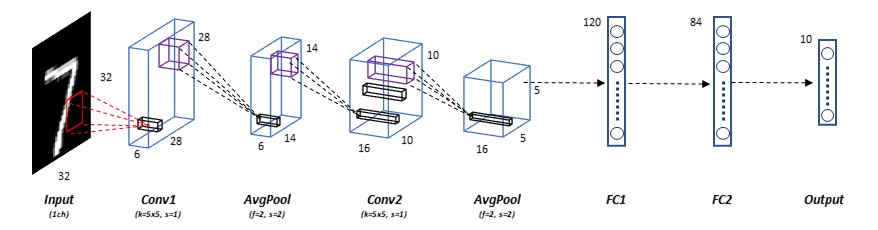

Si noti che la rete prevede immagini in input di 32x32 pixel (in scala di grigi, quindi su singolo canale), mentre il dataset usato nell'esempio presenta immagini di 28x28 pixel. Per ovviare al problema, usare un semplice resize delle immagini. Infine, si noti che la funzione di attivazione usata è la tangente iperbolica. Si sperimenti l'uso di differenti funzioni di loss e algoritmi di ottimizzazione.

# Soluzione

NOTA: La soluzione riportata utilizza una singola funzione di loss e un singolo ottimizzatore. Si noti inoltre che la soluzione riportata prevede l'utilizzo di un flattener e di un layer fully-connected per arrivare ad un array di feature. Una soluzione alternativa (molto più comunemente applicata) consiste nell'uso di un ulteriore layer convoluzionale dopo il secondo operatore di pooling.


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
import torch.nn.functional as funct
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

#################################################
#              Codice di supporto               #
#################################################

#Definizione dell'architettura di rete che vogliamo usare
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1)   
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)    
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                                                  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = funct.tanh(x)
        x = funct.avg_pool2d(x, 2)

        x = self.conv2(x)
        x = funct.tanh(x)
        x = funct.avg_pool2d(x, 2)

        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = funct.tanh(x)

        x = self.fc2(x)
        x = funct.tanh(x)

        logits = self.fc3(x)
        out = funct.softmax(logits, dim=1)

        return out

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)

#Creiamo un metodo che, a partire da Dati e Labels, calcoli Loss e Accuracy (dato che lo useremo per training, test e validation)
def valutaOutputEPerformance(modello, criterion, dati, labels):
  if torch.cuda.is_available():
    dati = dati.cuda()
    labels = labels.cuda()
  
  output = modello(dati) 
  loss = criterion(output, labels) 
  campioniCorretti = (torch.max(output, 1)[1].view(labels.size()).data == labels).sum()
  accuracy = 100.0 * campioniCorretti/dati.size(0)
  return(output, loss, accuracy.item())

#################################################
#    Codice per lo svolgimento della traccia    #
#################################################

#Parametri di addestramento
epoche = 15
dimBatchTrain = 64
dimBatchVal = 64
dimBatchTest = 128
lr = 0.01              #learning rate
momentum = 0.5

#Preparazione dei dataset
trasf = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainingSet = datasets.MNIST('MNIST_data/', download=True, train=True, transform=trasf)
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.20)
testSet = datasets.MNIST('MNIST_data/', download=True, train=False, transform=trasf)
trainingLoader = DataLoader(trainingSet, batch_size = dimBatchTrain, shuffle=True)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=True)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=True)

#Instanziazione della rete, loss e algortimo di ottimizzazione
modello = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modello.parameters(), lr=lr)

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
modello.to(device)

#Ciclo di addestramento
lossTraining = []
accuracyTraining = []
lossValidation = []
accuracyValidation = []

for e in range(1, epoche + 1):
  lossTrainEpoca = 0
  lossValEpoca = 0
  for datiBatchTrain, labelsBatchTrain in trainingLoader:
      outputTrain, lossTrain, accuracyTrain = valutaOutputEPerformance(modello, criterion, datiBatchTrain, labelsBatchTrain)      
      optimizer.zero_grad()
      lossTrain.backward()
      optimizer.step()
      lossTrainEpoca += lossTrain.item()*datiBatchTrain.size(0)    
  lossTraining.append(lossTrainEpoca/len(trainingLoader))
  accuracyTraining.append(accuracyTrain)

  #Calcolo delle performance sul validation set, ad ogni fine epoca
  for datiBatchVal, labelsBatchVal in validationLoader:
      outputVal, lossVal, accuracyVal = valutaOutputEPerformance(modello, criterion, datiBatchVal, labelsBatchVal)      
      lossValEpoca += lossVal.item()*datiBatchVal.size(0)    
  lossValidation.append(lossValEpoca/len(validationLoader))
  accuracyValidation.append(accuracyVal)
  
  print("Epoca {}:".format(e))
  print("Loss sul Training Set: {} - Accuracy sul Training Set: {}".format(lossTraining[-1:], np.mean(accuracyTraining)))
  print("Loss sul Validation Set: {} - Accuracy sul Validation Set: {}".format(lossValidation[-1:], np.mean(accuracyValidation)))
  print("--------------------------------------------------------------------------------------------------")

#Visualizzazione delle training curves
plt.figure()

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, epoche, 1), lossTraining, label="Training Loss", color="black")
plt.plot(np.arange(0, epoche, 1), lossValidation, label="Validation Loss", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, epoche, 1), accuracyTraining, label="Training Accuracy", color="black")
plt.plot(np.arange(0, epoche, 1), accuracyValidation, label="Validation Accuracy", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")

#Calcolo delle performance finali sul test set
accuracyTest = []
campioniTotaliTest = 0
for datiBatchTest, labelsBatchTest in testLoader:
  outputTest, lossTest, accuracyT = valutaOutputEPerformance(modello, criterion, datiBatchTest, labelsBatchTest)       
  accuracyTest.append(accuracyT)
  campioniTotaliTest += datiBatchTest.size(0);
print("Numero di campioni nel test set =", campioniTotaliTest)
print("\nAccuracy sul test set =", np.mean(accuracyTest))